In [1]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import random as rn 
import warnings
warnings.filterwarnings("ignore")

In [2]:

# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


In [3]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [4]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [5]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [6]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [7]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [8]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [9]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [10]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [11]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [12]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [13]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [14]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [15]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [16]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [17]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [18]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

### common cells:

In [19]:
common_cells_across_methods = pd.read_csv("../../../../results/Fig6-Granja_PBMC_scATAC/compare_annotation_performances/commonCells.csv", index_col=False)
common_cells_across_methods

,0
0,GGGTGTCAGGTTTCTG-1
1,AATGTCGCATGACTGT-1
2,TACCTCGCAGTCAGCC-1
3,TACCTATCATTAAGGA-1
4,GCGCCAAGTAGAACGC-1
...,...
2425,GCCAGACTCCGGAAAG-1
2426,ACAGGCCTCATCGCAA-1
2427,GGGAACATCTGGCACG-1
2428,AGCCCGAGTTCTGAAC-1


### silver ground truth annotations - from original publication


In [20]:
ground_truth_annotations = pd.read_csv("../../../../data/Granja2019/PBMC_D10T1/03_cellIDs_and_annotations/metadata.csv")

In [21]:
ground_truth_annotations = ground_truth_annotations[["BioClassification", "Barcode"]]
ground_truth_annotations[['cluster_id', 'annotation']] = ground_truth_annotations['BioClassification'].str.split('_', n=1, expand=True)
ground_truth_annotations.index=ground_truth_annotations['Barcode']
ground_truth_annotations.index.name = None
ground_truth_annotations.columns = ["BioClassification","cell_IDs","cluster_id","annotation"]

In [22]:
ground_truth_renaming_dict={'B':'Bcell',
 'CD14.Mono.1':'Mono',
 'CD14.Mono.2':'Mono',
 'CD4.M':'CD4Tcell',
 'CD4.N1':'CD4Tcell',
 'CD4.N2':'CD4Tcell',
 'CD8.CM':'CD8Tcell',
 'CD8.EM':'CD8Tcell',
 'CD8.N':'CD8Tcell',
 'Early.Baso':'Basofil',
 'GMP':'GMP',
 'HSC':'HSC/MPP',
 'NK':'NKcell',
 'Plasma':'Plasmacell',
 'Unk':'Unknown',
 'cDC':'DC',
 'pDC':'DC',
 'CLP.1': 'CLP',
 'CLP.2': 'CLP',
 'CMP.LMPP': 'CMP/LMPP',
 'Early.Eryth': 'Ery',
 'GMP.Neut': 'GMP',
 'Late.Eryth': 'Ery',
 'Pre.B': 'CLP'}

In [23]:
ground_truth_annotations= ground_truth_annotations.assign(ground_truth_annotations_simplified=list(ground_truth_annotations['annotation'].map(ground_truth_renaming_dict)))
ground_truth_annotations.head()

,BioClassification,cell_IDs,cluster_id,annotation,ground_truth_annotations_simplified
TCAGGGCAGGGCATTG-1,21_CD4.N2,TCAGGGCAGGGCATTG-1,21,CD4.N2,CD4Tcell
GTTCAAGCAGTTACAC-1,22_CD4.M,GTTCAAGCAGTTACAC-1,22,CD4.M,CD4Tcell
CATTCCGGTGATAACA-1,22_CD4.M,CATTCCGGTGATAACA-1,22,CD4.M,CD4Tcell
GCGTTGGTCCAGTTAG-1,21_CD4.N2,GCGTTGGTCCAGTTAG-1,21,CD4.N2,CD4Tcell
TCAAAGCCAAGCACTT-1,26_Unk,TCAAAGCCAAGCACTT-1,26,Unk,Unknown


In [24]:
ground_truth_annotations_known = ground_truth_annotations[ground_truth_annotations['ground_truth_annotations_simplified']!= "Unknown"]

In [25]:
ground_truth_annotations.shape

(2891, 5)

In [26]:
ground_truth_annotations.annotation.value_counts()

annotation
CD14.Mono.2    867
CD4.N2         613
CD4.M          434
Unk            270
B              221
NK             168
CD8.CM         107
CD8.EM          83
cDC             67
Plasma          21
pDC             15
Early.Baso       8
CD14.Mono.1      7
CD4.N1           6
GMP              2
HSC              1
CD8.N            1
Name: count, dtype: int64

In [27]:
ground_truth_annotations.ground_truth_annotations_simplified.value_counts()

ground_truth_annotations_simplified
CD4Tcell      1053
Mono           874
Unknown        270
Bcell          221
CD8Tcell       191
NKcell         168
DC              82
Plasmacell      21
Basofil          8
GMP              2
HSC/MPP          1
Name: count, dtype: int64

In [28]:
ground_truth_annotations_known.shape

(2621, 5)

In [29]:
ground_truth_annotations_known.head()

,BioClassification,cell_IDs,cluster_id,annotation,ground_truth_annotations_simplified
TCAGGGCAGGGCATTG-1,21_CD4.N2,TCAGGGCAGGGCATTG-1,21,CD4.N2,CD4Tcell
GTTCAAGCAGTTACAC-1,22_CD4.M,GTTCAAGCAGTTACAC-1,22,CD4.M,CD4Tcell
CATTCCGGTGATAACA-1,22_CD4.M,CATTCCGGTGATAACA-1,22,CD4.M,CD4Tcell
GCGTTGGTCCAGTTAG-1,21_CD4.N2,GCGTTGGTCCAGTTAG-1,21,CD4.N2,CD4Tcell
TTGACGACATATAGAG-1,12_CD14.Mono.2,TTGACGACATATAGAG-1,12,CD14.Mono.2,Mono


In [30]:
leiden_resolutions = ['0.1' ,'0.2' ,'0.3' ,'0.4' ,'0.5' ,'0.6' ,'0.7' ,'0.8' ,'0.9' ,'1.0' ,'1.1' ,'1.2' ,'1.3' ,'1.4' ,'1.5' ,'1.6' ,'1.7','1.8' ,'1.9' ,'2.0', '2.1', '2.2', '2.3', '2.4', '2.5']

In [31]:
# prepare results dataframe

scores_df = pd.DataFrame( index=['leiden_'+i for i in leiden_resolutions])

In [32]:
for res in leiden_resolutions:
    result_path = "../../../../results/Supplementary_tables/analysis_on_clustering_parameter/Granja_PBMC_scATAC_performance_acros_clustering_res/res"+ res + "/outputs/scATAcat_annotations_leiden_" + res +".csv"
    scATAcat_annotations = pd.read_csv(result_path, index_col=0)
    scATAcat_annotations.index.name = None
    scATAcat_annotations.columns = ['leiden_'+ res, 'scATAcat_annotation','cell_IDs']
    #scATAcat_annotations.columns = ['leiden_'+res, 'scATAcat_annotation' ,'ground_truth_annotations']
    scATAcat_annotations['cell_IDs'] = scATAcat_annotations.index
    
    cluster_id_column ='leiden_'+res
    scATAcat_annotations.index.name = None
    common_cells = list(common_cells_across_methods['0'])
    all_methods_for_commonCells= get_combined_annotations_df_for_common_cells(scATAcat_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
    common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
    print(common_annotations)
    all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
    annotation_df = all_methods_for_commonCells_commonAnnotations
    correct_id_col = 'ground_truth_annotations_simplified'
    predicted_id_col = "scATAcat_annotation"
    scores_df.loc['leiden_'+ res, "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
    scores_df.loc['leiden_'+ res, "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, 'num_clust'] = scATAcat_annotations['leiden_'+ res].max()+1


['Mono', 'CD4Tcell', 'NKcell', 'Bcell']
['Mono', 'CD4Tcell', 'NKcell', 'Bcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mono', 'CD8Tcell']
['CD4Tcell', 'NKcell', 'Bcell', 'Mon

In [33]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score,num_clust
leiden_0.1,0.997673,0.995114,1.000000,0.995572,0.997512,0.998434,0.996597,0.996364,0.994726,0.996363,5.0
leiden_0.2,0.996743,0.994591,1.000000,0.993747,0.996988,0.998431,0.995552,0.994913,0.992649,0.994912,5.0
leiden_0.3,0.984940,0.965164,1.000000,0.966651,0.991649,0.990615,0.992685,0.978051,0.978992,0.978048,7.0
leiden_0.4,0.982788,0.959148,1.000000,0.964041,0.988589,0.981462,0.995820,0.974904,0.972570,0.974866,8.0
leiden_0.5,0.984079,0.959877,1.000000,0.964715,0.990130,0.984504,0.995820,0.976780,0.977171,0.976753,9.0
leiden_0.6,0.984079,0.959877,1.000000,0.964696,0.990644,0.985522,0.995820,0.976779,0.977292,0.976754,10.0
leiden_0.7,0.983219,0.959357,1.000000,0.964671,0.989114,0.981481,0.996355,0.975534,0.973517,0.975489,10.0
leiden_0.8,0.982788,0.959148,1.000000,0.964041,0.988589,0.981462,0.995820,0.974904,0.972570,0.974866,10.0
leiden_0.9,0.982358,0.958905,1.000000,0.963817,0.988077,0.980453,0.995140,0.974280,0.971039,0.974236,10.0
leiden_1.0,0.983649,0.959668,1.000000,0.964069,0.990120,0.985507,0.994775,0.976151,0.976343,0.976131,11.0


In [35]:
scores_df.to_csv('../../../../results/Supplementary_tables/analysis_on_clustering_parameter/Granja_PBMC_scATAC_performance_acros_clustering_res/Granja_PBMC_scATAC_performance_acros_clustering_res.csv')

In [36]:
figures_dir = "../../../../results/Supplementary_tables/analysis_on_clustering_parameter/Granja_PBMC_performance_acros_clustering_res/figures/"

In [37]:
import os
os.makedirs(figures_dir,exist_ok=True)

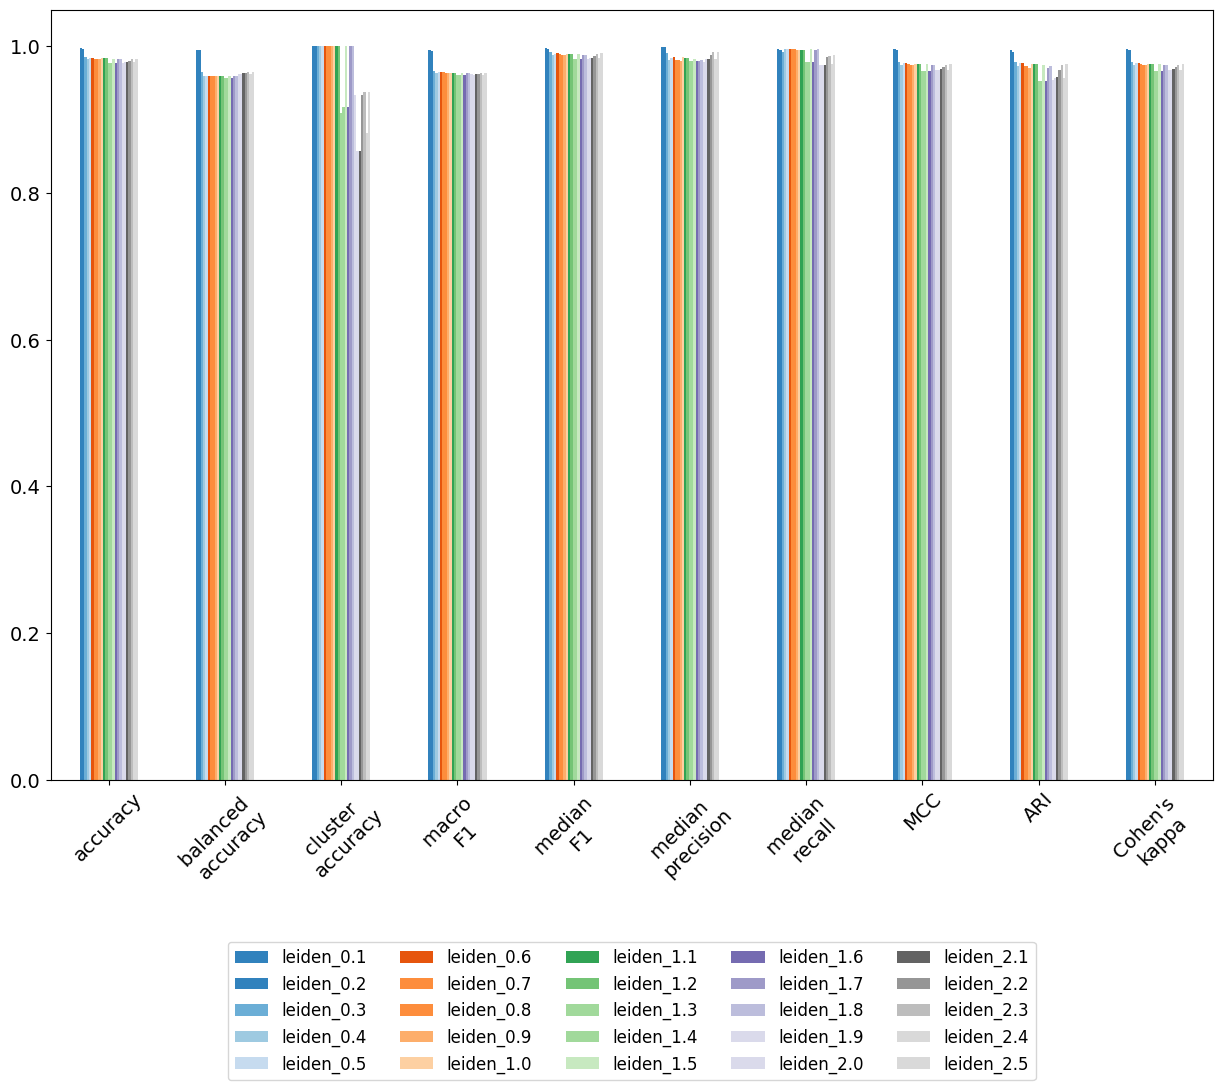

In [38]:
import matplotlib.pyplot as plt
scores_df = scores_df.iloc[:,:-1]
scores_df.columns = ['accuracy', 'balanced \naccuracy','cluster \naccuracy', 'macro \nF1', 'median \nF1',
                      'median \nprecision', 'median \nrecall','MCC', 'ARI', "Cohen's \nkappa"]

ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12,colormap='tab20c')
#ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=12)
#plt.title("evaluation scores for common cells and common annotations without EpiAnno", fontsize=15)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.show()
plt.savefig(figures_dir + "Granja_PBMC_performance_acros_clustering_res.png", bbox_inches='tight', transparent=True)
